In [1]:
!sudo apt-get install -y fonts-nanum
!sudo fc-cache -fv
!rm ~/.cache/matplotlib -rf

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
fonts-nanum is already the newest version (20200506-1).
0 upgraded, 0 newly installed, 0 to remove and 9 not upgraded.
/usr/share/fonts: caching, new cache contents: 0 fonts, 1 dirs
/usr/share/fonts/truetype: caching, new cache contents: 0 fonts, 3 dirs
/usr/share/fonts/truetype/humor-sans: caching, new cache contents: 1 fonts, 0 dirs
/usr/share/fonts/truetype/liberation: caching, new cache contents: 16 fonts, 0 dirs
/usr/share/fonts/truetype/nanum: caching, new cache contents: 12 fonts, 0 dirs
/usr/local/share/fonts: caching, new cache contents: 0 fonts, 0 dirs
/root/.local/share/fonts: skipping, no such directory
/root/.fonts: skipping, no such directory
/usr/share/fonts/truetype: skipping, looped directory detected
/usr/share/fonts/truetype/humor-sans: skipping, looped directory detected
/usr/share/fonts/truetype/liberation: skipping, looped directory detected
/usr/share/fonts/truetype/n

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pickle
from tqdm import tqdm

import matplotlib.pyplot as plt
plt.rc('font', family='NanumBarunGothic')

import warnings
warnings.filterwarnings('ignore')

In [3]:
ahu = pd.read_csv("/content/drive/MyDrive/ime_project/data/porest_area_ahu_automatic.csv")
chiller = pd.read_csv("/content/drive/MyDrive/ime_project/data/porest_area_chiller_automatic.csv")

ahu = ahu[['ahu_no','building','power','inv','occupancy','out_temp','in_temp','zone_min_temp','cdate']]
chiller = chiller[['chiller_no','temp','power','inv','cdate']]

column_e = ['no', 'id', 'seq', 'type', 'val', 'rv', 'ri', 'sv', 'si', 'tv', 'ti', 'fire', 'temperature', 'humidity', 'cdate']
e = pd.read_csv('/content/drive/MyDrive/ime_project/data/porest_device_e_log.csv', names=column_e)

column_plant = ["no", "id", "seq", "air", "monoxide", "dioxide", "pm2d5", "pm10", "temperature", "humidit", "score", "cdate"]
plant = pd.read_csv('/content/drive/MyDrive/ime_project/data/porest_device_plant_log.csv', names=column_plant)

# 장치 정보
devices = pd.read_excel("/content/drive/MyDrive/ime_project/data/porest_devices.xlsx",header=1)

In [4]:
ahu['cdate'] = pd.to_datetime(ahu['cdate'])
ahu.replace("\\N", np.nan, inplace=True)

chiller['cdate'] = pd.to_datetime(chiller['cdate'])
chiller.replace("\\N", np.nan, inplace=True)

e['cdate'] = pd.to_datetime(e['cdate'])
e.replace("\\N", np.nan, inplace=True)

plant['cdate'] = pd.to_datetime(plant['cdate'])
plant.replace("\\N", np.nan, inplace=True)

# AHU 전처리

In [5]:
# ahu 전처리, A 구역 없앤뒤
ahu_a = ahu[ahu['building'] == 'A']
ahu_a.drop(columns=['building'], inplace=True)
# 원래 ahu 칼럼에 있던 관측치를 기존제어라고 명명
ahu_a['how_0']='기존제어'

# 시계열 형태로 변경
ahu_a.set_index('cdate', inplace=True)
ahu_a.index = pd.to_datetime(ahu_a.index)

ahu_group = ahu_a.groupby('ahu_no')

start_date = '2023-01-31 10:00:00'
end_date = '2023-08-01 16:00:00'

ahu_dct = {}
for name, group_df in ahu_group:
  group_df.index = group_df.index.floor('10T') # 기존의 datetime을 10분 단위로 내림
  group_df = group_df.loc[~group_df.index.duplicated(keep='first')] # 내리는 과정에서 중복 발생시 중복 제거

  date_range = pd.date_range(start=start_date, end=end_date, freq='10T')
  group_df = group_df.reindex(date_range) # 10분 단위로 row를 생성

  ahu_dct[name] = group_df
  ahu_dct[name]['ahu_no'] = name

In [6]:
ahu_dct[1].head()

,ahu_no,power,inv,occupancy,out_temp,in_temp,zone_min_temp,how_0
2023-01-31 10:00:00,1,1.0,30.0,8.0,24.0,NaN,NaN,기존제어
2023-01-31 10:10:00,1,1.0,30.0,8.0,24.0,NaN,NaN,기존제어
2023-01-31 10:20:00,1,1.0,30.0,8.0,25.0,NaN,NaN,기존제어
2023-01-31 10:30:00,1,1.0,30.0,8.0,25.0,NaN,NaN,기존제어
2023-01-31 10:40:00,1,1.0,30.0,8.0,25.0,NaN,NaN,기존제어


In [7]:
alog = pd.read_csv("/content/drive/MyDrive/ime_project/data/porest_area_log.csv", usecols=[2, 3, 4, 6, 7], names=['type', 'mode', 'text', 'cdate_0', 'cdate_1'], header=None)
alog['text'] = alog['text'].str.replace('::',',').str.replace('[','').str.replace(']',',').str.replace('\\','').str.replace(':',',')
alog = alog[(alog['type'] == 'freezer')|(alog['type'] == 'ahu')].reset_index(drop=True)
alog[['device', 'how_0', 'how_1', 'power']] = pd.DataFrame(alog.text.str.rsplit(',', 3).tolist())
alog[['name', 'day']] = pd.DataFrame(alog.device.str.rsplit(',', 1).tolist())
alog['device'] = alog['name'].str.replace(',','')
alog['cdate'] = np.where(pd.isna(alog['cdate_0']), alog['cdate_1'], alog['cdate_0'])
alog['cdate'] = pd.to_datetime(alog['cdate'])
alog['cdate'] = alog['cdate'].dt.round('10min')

alog_filtered = alog[['type', 'mode', 'device', 'how_0', 'how_1', 'power', 'day', 'cdate']]

# device를 name과 number로 분리
alog_filtered['dname'] = alog_filtered['device'].str.extract('([가-힣]+)')
alog_filtered['dnumber'] = alog_filtered['device'].str.extract('(\d+)')
alog_filtered['dnumber'] = alog_filtered['dnumber'].astype('int')
alog_filtered.drop('device', axis=1, inplace=True)
# 시계열 형태로 변경
alog_filtered.set_index('cdate', inplace=True)
alog_filtered.index = pd.to_datetime(alog_filtered.index)

alog_filtered = alog_filtered.loc[start_date:end_date] # 시간 shorting
alog_filtered = alog_filtered[alog_filtered['how_0'] != '자동제어변경'] # 자동제어변경 제외

ahu_plus = alog_filtered[alog_filtered['type']=='ahu']
ahu_plus = ahu_plus.rename(columns={'dnumber':'ahu_no'})

# chiller_plus = alog_filtered[alog_filtered['type']=='freezer']

ahu_plus = ahu_plus[ahu_plus['ahu_no']<=14] # A 빌딩안에 있는 1~14만 남김

start_date = '2023-01-31 10:00:00'
end_date = '2023-08-01 16:00:00'
ahu_group = ahu_plus.groupby('ahu_no')
ahu_plus_dct = {}

for name, group_df in ahu_group:
  ahu_plus_dct[name] = group_df
  # ahu_plus_dct[name].loc

In [8]:
ahu_plus_dct[1].head()

,type,mode,how_0,how_1,power,day,dname,ahu_no
cdate,,,,,,,,
2023-01-31 13:40:00,ahu,0,수동제어,전원,0,None,공조기,1
2023-01-31 19:00:00,ahu,1,스케줄제어,전원,0,None,공조기,1
2023-02-01 08:50:00,ahu,1,스케줄제어,전원,1,None,공조기,1
2023-02-01 11:40:00,ahu,0,수동제어,인버터,32Hz,None,공조기,1
2023-02-01 19:00:00,ahu,1,스케줄제어,전원,0,None,공조기,1


In [9]:
ahu_fin_dct = {}

for i in range(1,15): # 총 ahu는 14개
    ### 스케줄 제어
    ahu_plus1 = ahu_plus_dct[i]
    ahu1 = ahu_dct[i]

    ahu_sch1 = ahu_plus1[ahu_plus1['how_0']=='스케줄제어']
    date_range = pd.date_range(start=start_date, end=end_date, freq='10T')
    ahu_sch1 = ahu_sch1.reindex(date_range) # 스케줄 제어를 10분 단위로 만든다. 결측치는 NaN으로
    ahu_sch1 = ahu_sch1.fillna(method='ffill') # ffill로 결측치를 채운다.
    ahu1_com = ahu1.combine_first(ahu_sch1)

    ### 수동제어
    ahu_man1 = ahu_plus1[ahu_plus1['how_0']=='수동제어']
    # ahu_onoff1 = ahu_man1[ahu_man1['how_1']=='전원'] # power는 0,1 로 이루어져 있다. 근데 기존데이터와 너무 겹치는것도 많고 어떤 데이터가 옿은지 모르겠음
    ahu_inv1 = ahu_man1[ahu_man1['how_1']=='인버터'] # power는 Hz 값으로 이루어져 있다. >> inv 칼럼으로 이동

    ahu_inv1 = ahu_man1[ahu_man1['how_1']=='인버터']
    ahu_inv1['method'] = ahu_inv1['how_1']

    date_range = pd.date_range(start=start_date, end=end_date, freq='10T')
    ahu_inv1 = ahu_inv1[~ahu_inv1.index.duplicated(keep='first')]
    ahu_inv1 = ahu_inv1.reindex(date_range) # 스케줄 제어를 10분 단위로 만든다. 결측치는 NaN으로
    ahu_inv1 = ahu_inv1.fillna(method='ffill') # ffill로 결측치를 채운다.
    ahu_inv1['power'] = ahu_inv1['power'].str.replace('Hz', '') # Hz 날린다.

    ahu_inv1.rename(columns={'power':'inv'}, inplace=True)
    ahu1_comm = ahu1_com.combine_first(ahu_inv1)
    # 인버터 수동제어하는 파트(method='인버터')만 how_0, how_1 각각 바꿔준다.
    ahu1_comm.loc[ahu1_comm['method'].notnull(), 'how_0'] = '수동제어'
    ahu1_comm.loc[ahu1_comm['method'].notnull(), 'how_1'] = '인버터'
    ahu1_comm.drop('method', axis=1, inplace=True)
    ahu_fin_dct[i] = ahu1_comm

In [10]:
ahu_fin_dct[1].head()

,ahu_no,day,dname,how_0,how_1,in_temp,inv,mode,occupancy,out_temp,power,type,zone_min_temp
2023-01-31 10:00:00,1.0,NaN,NaN,기존제어,NaN,NaN,30.0,NaN,8.0,24.0,1.0,NaN,NaN
2023-01-31 10:10:00,1.0,NaN,NaN,기존제어,NaN,NaN,30.0,NaN,8.0,24.0,1.0,NaN,NaN
2023-01-31 10:20:00,1.0,NaN,NaN,기존제어,NaN,NaN,30.0,NaN,8.0,25.0,1.0,NaN,NaN
2023-01-31 10:30:00,1.0,NaN,NaN,기존제어,NaN,NaN,30.0,NaN,8.0,25.0,1.0,NaN,NaN
2023-01-31 10:40:00,1.0,NaN,NaN,기존제어,NaN,NaN,30.0,NaN,8.0,25.0,1.0,NaN,NaN


In [11]:
ahu1 = ahu_fin_dct[1]
ahu1col = list(ahu1.columns)

for i in range(len(ahu1col)):
  print(f'{ahu1col[i]:<{15}} 결측치: {(ahu1[ahu1col[i]].isna().sum()/len(ahu1[ahu1col[i]]))*100:.2f} %')

## 결측치가 95%가 있는 in_temp, occupancy, out_temp, zone_min_temp 제거
for i in range(1,15):
  ahu_fin_dct[i].drop(['in_temp','occupancy','out_temp','zone_min_temp'], axis=1, inplace=True)

ahu_no          결측치: 0.00 %
day             결측치: 2.70 %
dname           결측치: 0.21 %
how_0           결측치: 0.13 %
how_1           결측치: 0.21 %
in_temp         결측치: 94.51 %
inv             결측치: 0.51 %
mode            결측치: 0.21 %
occupancy       결측치: 94.41 %
out_temp        결측치: 94.41 %
power           결측치: 0.13 %
type            결측치: 0.21 %
zone_min_temp   결측치: 94.53 %


In [12]:
ahu1 = ahu_fin_dct[1]
ahu1col = list(ahu1.columns)

for i in range(len(ahu1col)):
  print(f'{ahu1col[i]:<{15}} 결측치: {(ahu1[ahu1col[i]].isna().sum()/len(ahu1[ahu1col[i]]))*100:.2f} %')

ahu_no          결측치: 0.00 %
day             결측치: 2.70 %
dname           결측치: 0.21 %
how_0           결측치: 0.13 %
how_1           결측치: 0.21 %
inv             결측치: 0.51 %
mode            결측치: 0.21 %
power           결측치: 0.13 %
type            결측치: 0.21 %


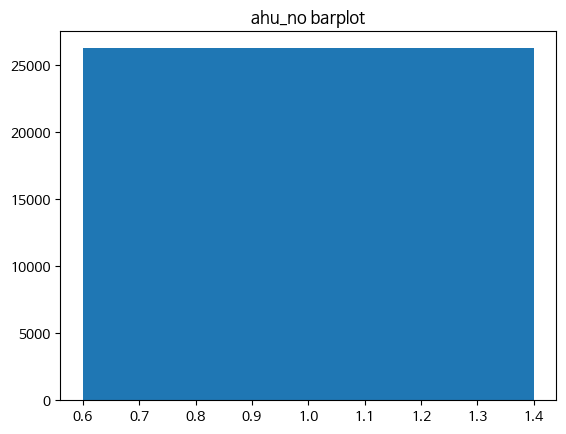

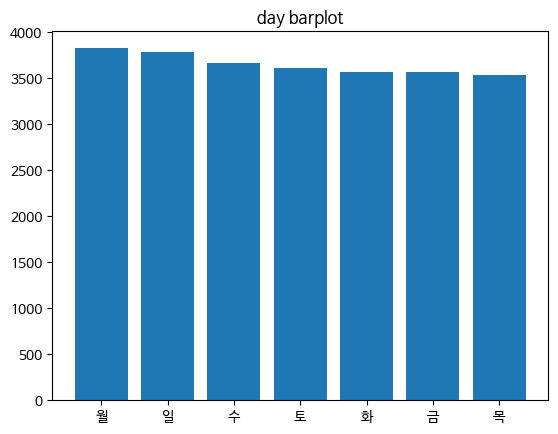

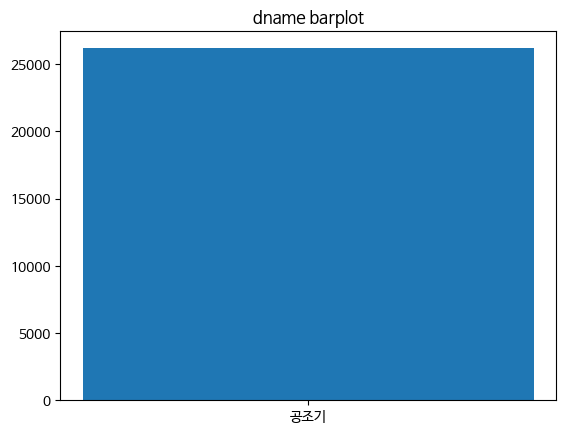

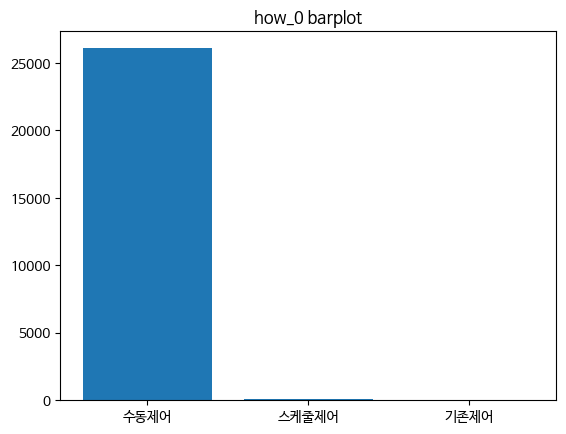

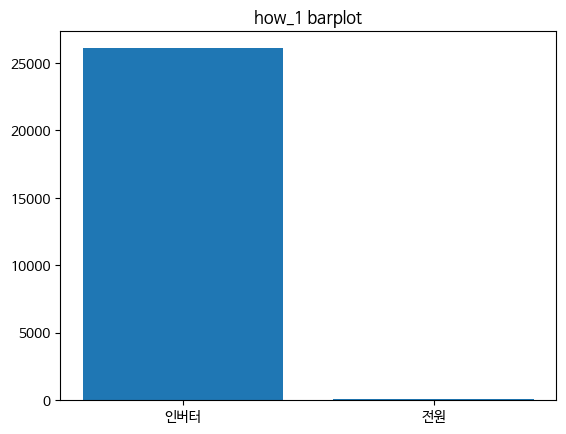

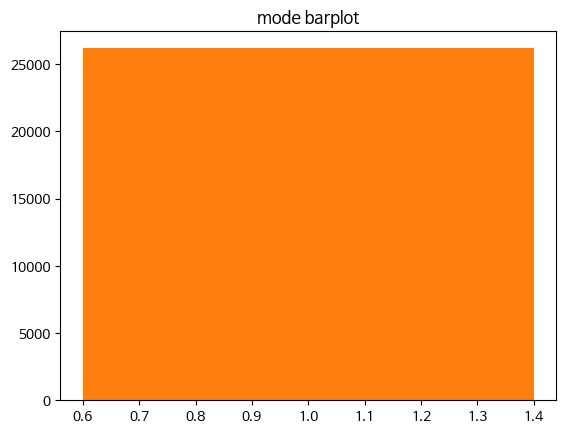

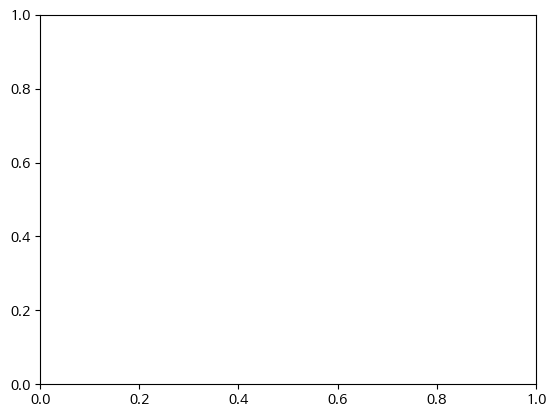

In [13]:
for i in range(len(ahu1col)):
  try:
      value_counts = ahu1[ahu1col[i]].value_counts()
      plt.bar(value_counts.index, value_counts.values)
      plt.title(f'{ahu1col[i]} barplot')
      plt.show()
  except:
      pass

In [14]:
# with open("/content/drive/MyDrive/ime_project/done/ahu_complete.pkl", 'wb') as file:
#     pickle.dump(ahu_fin_dict, file)

In [44]:
ahu_fin_dct[1].to_csv('/content/drive/MyDrive/ime_project/done/ahu1_complete.csv')

# Chiller 전처리

In [15]:
chiller = pd.read_csv("/content/drive/MyDrive/ime_project/data/porest_area_chiller_automatic.csv")
chiller = chiller[['chiller_no','temp','power','inv','cdate']]

chiller.set_index('cdate', inplace=True)
chiller.index = pd.to_datetime(chiller.index)

chiller_group = chiller.groupby('chiller_no') ## chiller -> 1,2 로 구성

chiller_dct = {}
for name, group_df in chiller_group:
  group_df.index = group_df.index.floor('10T') # 기존의 datetime을 10분 단위로 내림
  group_df = group_df.loc[~group_df.index.duplicated(keep='first')] # 내리는 과정에서 중복 발생시 중복 제거

  date_range = pd.date_range(start=start_date, end=end_date, freq='10T')
  group_df = group_df.reindex(date_range) # 10분 단위로 row를 생성

  chiller_dct[name] = group_df
  chiller_dct[name]['chiller_no'] = name

In [16]:
chiller_dct[1].head()

,chiller_no,temp,power,inv
2023-01-31 10:00:00,1,NaN,NaN,NaN
2023-01-31 10:10:00,1,\N,1.0,40.0
2023-01-31 10:20:00,1,\N,1.0,40.0
2023-01-31 10:30:00,1,\N,1.0,40.0
2023-01-31 10:40:00,1,\N,1.0,40.0


In [17]:
start_date = '2023-01-31 10:00:00'
end_date = '2023-08-01 16:00:00'

alog = pd.read_csv("/content/drive/MyDrive/ime_project/data/porest_area_log.csv", usecols=[2, 3, 4, 6, 7],
                    names=['type', 'mode', 'text', 'cdate_0', 'cdate_1'], header=None)
alog['text'] = alog['text'].str.replace('::',',').str.replace('[','').str.replace(']',',').str.replace('\\','').str.replace(':',',')
alog = alog[(alog['type'] == 'freezer')|(alog['type'] == 'ahu')].reset_index(drop=True)
alog[['device', 'how_0', 'how_1', 'power']] = pd.DataFrame(alog.text.str.rsplit(',', 3).tolist())
alog[['name', 'day']] = pd.DataFrame(alog.device.str.rsplit(',', 1).tolist())
alog['device'] = alog['name'].str.replace(',','')
alog['cdate'] = np.where(pd.isna(alog['cdate_0']), alog['cdate_1'], alog['cdate_0'])
alog['cdate'] = pd.to_datetime(alog['cdate'])
alog['cdate'] = alog['cdate'].dt.round('10min')

alog_filtered = alog[['type', 'mode', 'device', 'how_0', 'how_1', 'power', 'day', 'cdate']]

# device를 name과 number로 분리
alog_filtered['dname'] = alog_filtered['device'].str.extract('([가-힣]+)')
alog_filtered['dnumber'] = alog_filtered['device'].str.extract('(\d+)')
alog_filtered['dnumber'] = alog_filtered['dnumber'].astype('int')
alog_filtered.drop('device', axis=1, inplace=True)
# 시계열 형태로 변경
alog_filtered.set_index('cdate', inplace=True)
alog_filtered.index = pd.to_datetime(alog_filtered.index)

alog_filtered = alog_filtered.loc[start_date:end_date] # 시간 shorting
alog_filtered = alog_filtered[alog_filtered['how_0'] != '자동제어변경'] # 자동제어변경 제외

# ahu_plus = alog_filtered[alog_filtered['type']=='ahu']
# ahu_plus = ahu_plus.rename(columns={'dnumber':'ahu_no'})

chiller_plus = alog_filtered[alog_filtered['type']=='freezer']

chiller_group = chiller_plus.groupby('dnumber')
chiller_plus_dct = {}

for name, group_df in chiller_group:
    chiller_plus_dct[name] = group_df

In [18]:
chiller_plus_dct[1].head()

,type,mode,how_0,how_1,power,day,dname,dnumber
cdate,,,,,,,,
2023-02-01 21:00:00,freezer,1,스케줄제어,전원,0,수,열원설비,1
2023-02-06 09:20:00,freezer,1,스케줄제어,전원,1,월,열원설비,1
2023-02-06 13:00:00,freezer,0,수동제어,인버터,45Hz,None,열원설비,1
2023-02-06 13:20:00,freezer,0,수동제어,인버터,45Hz,None,열원설비,1
2023-02-06 13:40:00,freezer,0,수동제어,인버터,45Hz,None,열원설비,1


In [19]:
chi_fin_dct = {}

for i in range(1,3):
    chi1 = chiller_dct[i]
    chi_plus1 = chiller_plus_dct[i]

    ## 스케줄제어
    chi_sch1 = chi_plus1[chi_plus1['how_0']=='스케줄제어']
    date_range = pd.date_range(start=start_date, end=end_date, freq='10T')
    chi_sch1 = chi_sch1.reindex(date_range) # 스케줄 제어를 10분 단위로 만든다. 결측치는 NaN으로
    chi_sch1 = chi_sch1.fillna(method='ffill') # ffill로 결측치를 채운다.
    chi1_com = chi1.combine_first(chi_sch1)

    ## 수동제어
    chi_man1 = chi_plus1[chi_plus1['how_0']=='수동제어']
    # chi_onoff1 = chi_man1[chi_man1['how_1']=='전원'] # power는 0,1 로 이루어져 있다. 근데 기존데이터와 너무 겹치는것도 많고 어떤 데이터가 옿은지 모르겠음
    chi_inv1 = chi_man1[chi_man1['how_1']=='인버터'] # power는 Hz 값으로 이루어져 있다. >> inv 칼럼으로 이동

    chi_inv1 = chi_man1[chi_man1['how_1']=='인버터']
    chi_inv1['method'] = chi_inv1['how_1']

    date_range = pd.date_range(start=start_date, end=end_date, freq='10T')
    chi_inv1 = chi_inv1[~chi_inv1.index.duplicated(keep='first')]
    chi_inv1 = chi_inv1.reindex(date_range) # 스케줄 제어를 10분 단위로 만든다. 결측치는 NaN으로
    chi_inv1 = chi_inv1.fillna(method='ffill') # ffill로 결측치를 채운다.
    chi_inv1['power'] = chi_inv1['power'].str.replace('Hz', '') # Hz 날린다.

    chi_inv1.rename(columns={'power':'inv'}, inplace=True)

    ## 기존 + 스케줄제어 + 수동제어 병합
    chi1_comm = chi1_com.combine_first(chi_inv1)
    # 인버터 수동제어하는 파트(method='인버터')만 how_0, how_1 각각 바꿔준다.
    chi1_comm.loc[chi1_comm['method'].notnull(), 'how_0'] = '수동제어'
    chi1_comm.loc[chi1_comm['method'].notnull(), 'how_1'] = '인버터'
    chi1_comm.drop('method', axis=1, inplace=True)
    chi1_comm.drop('dnumber', axis=1, inplace=True)
    # chi1_comm = chi1_comm[['chiller_no','temp','power','inv']]
    # chi1_comm.drop('day', axis=1, inplace=True)
    chi1_comm['type'] = 'freezer'

    chi_fin_dct[i] = chi1_comm

In [20]:
chi_fin_dct[1].head()

,chiller_no,day,dname,how_0,how_1,inv,mode,power,temp,type
2023-01-31 10:00:00,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,freezer
2023-01-31 10:10:00,1,NaN,NaN,NaN,NaN,40.0,NaN,1.0,\N,freezer
2023-01-31 10:20:00,1,NaN,NaN,NaN,NaN,40.0,NaN,1.0,\N,freezer
2023-01-31 10:30:00,1,NaN,NaN,NaN,NaN,40.0,NaN,1.0,\N,freezer
2023-01-31 10:40:00,1,NaN,NaN,NaN,NaN,40.0,NaN,1.0,\N,freezer


In [21]:
chi1 = chi_fin_dct[1]
chi1col = list(chi1.columns)

for i in range(len(chi1col)):
    print(f'{chi1col[i]:<{15}} 결측치: {(chi1[chi1col[i]].isna().sum()/len(chi1[chi1col[i]]))*100:.2f} %')

# temp 제거
for i in range(1,3):
    chi_fin_dct[i].drop('temp', axis=1, inplace=True)

chiller_no      결측치: 0.00 %
day             결측치: 0.80 %
dname           결측치: 0.80 %
how_0           결측치: 0.80 %
how_1           결측치: 0.80 %
inv             결측치: 2.87 %
mode            결측치: 0.80 %
power           결측치: 0.37 %
temp            결측치: 93.64 %
type            결측치: 0.00 %


In [22]:
chi1 = chi_fin_dct[1]
chi1col = list(chi1.columns)

for i in range(len(chi1col)):
    print(f'{chi1col[i]:<{15}} 결측치: {(chi1[chi1col[i]].isna().sum()/len(chi1[chi1col[i]]))*100:.2f} %')

chiller_no      결측치: 0.00 %
day             결측치: 0.80 %
dname           결측치: 0.80 %
how_0           결측치: 0.80 %
how_1           결측치: 0.80 %
inv             결측치: 2.87 %
mode            결측치: 0.80 %
power           결측치: 0.37 %
type            결측치: 0.00 %


In [45]:
chi_fin_dct[1].to_csv('/content/drive/MyDrive/ime_project/done/chi1_complete.csv')

In [23]:
# with open("/content/drive/MyDrive/ime_project/done/chiller_complete.pkl", 'wb') as file:
#     pickle.dump(chi_fin_dict, file)

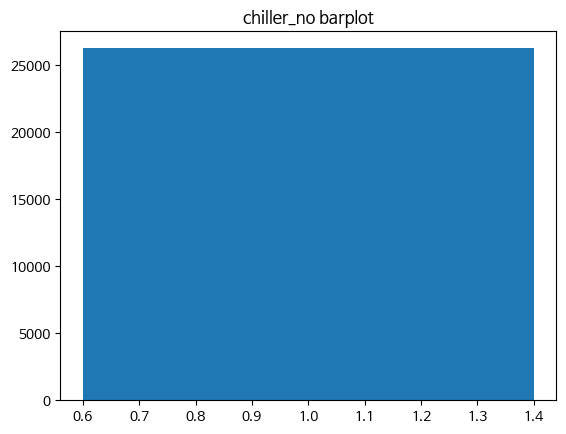

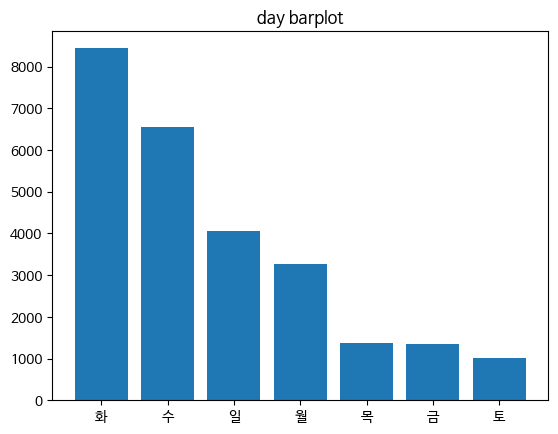

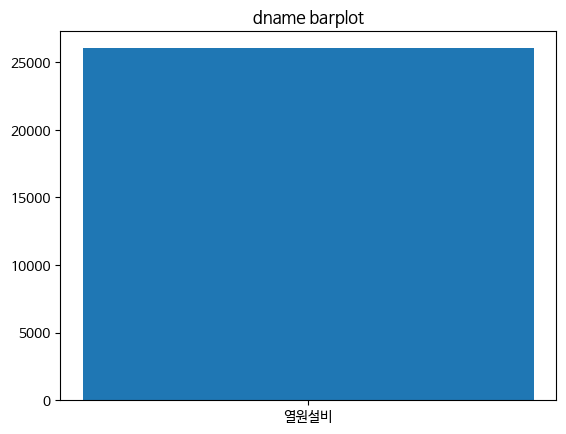

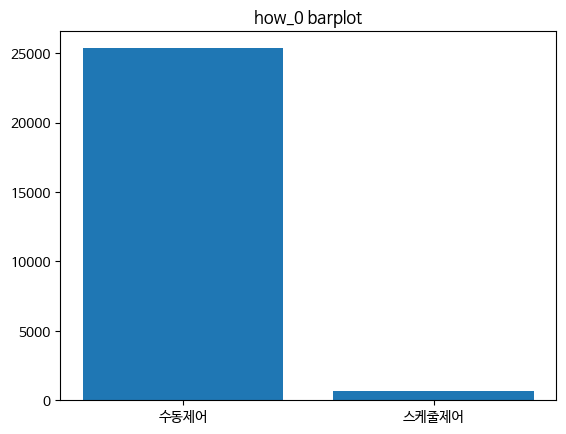

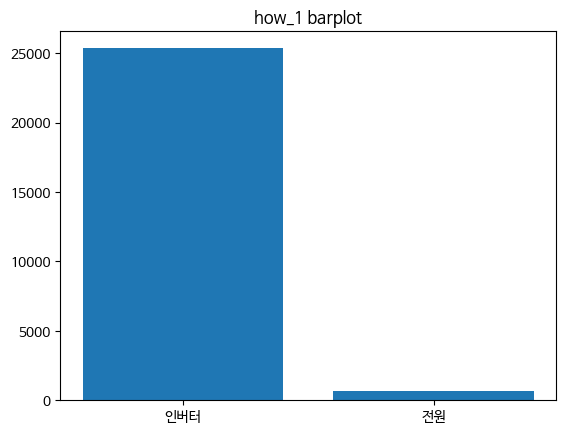

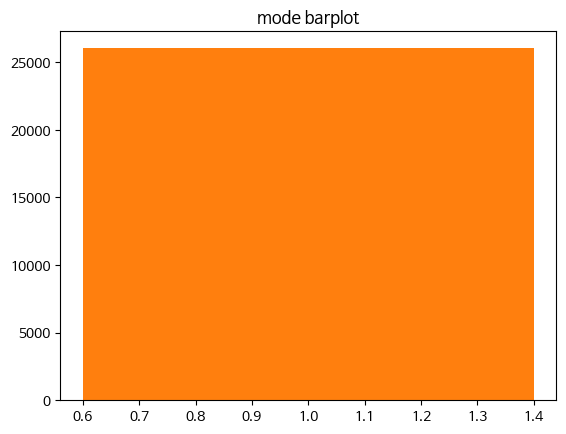

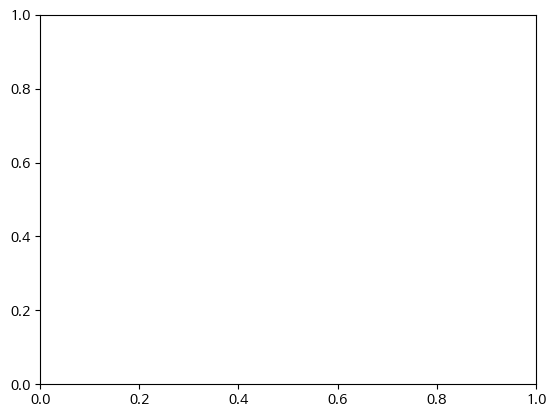

In [24]:
for i in range(len(chi1col)):
  try:
      value_counts = chi1[chi1col[i]].value_counts()
      plt.bar(value_counts.index, value_counts.values)
      plt.title(f'{chi1col[i]} barplot')
      plt.show()
  except:
      pass

# devices 전처리

In [25]:
# ahu_no에 해당하는 id_e와 id_plant 정보 mapping
devices = pd.read_excel("/content/drive/MyDrive/ime_project/data/porest_devices.xlsx",header=1)
devices.head()

,no,id_e,name,place,id_plant
0,1,c2-04-d8-a0-1d-58-c7-68,AHU-A/F1/1,Sale Area Zone1,c2-01-d8-a0-1d-58-cf-50
1,2,c2-04-d8-a0-1d-58-c7-28,AHU-A/F1/2,Sale Area Zone2,c2-01-d8-a0-1d-58-cf-50
2,3,c2-04-d8-a0-1d-58-ca-b0,AHU-A/F1/3,Sale Area Zone3,c2-01-d8-a0-1d-58-cf-50
3,4,c2-04-d8-a0-1d-58-c8-0c,AHU-A/F1/4,Sale Area Zone4,c2-01-d8-a0-1d-58-ca-e4
4,5,c2-04-d8-a0-1d-58-c6-b8,AHU-A/F1/5,Sale Area Zone5,c2-01-d8-a0-1d-58-ca-e4


In [26]:
devices_info = devices.iloc[:14].drop(['name','place'], axis=1)

# id_e를 device에 mapping
id_e2device = {devices_info['id_e'][i] : devices_info['no'][i] for i in range(14)}
# device를 id_plant에 mapping
device2id_plant = {devices_info['no'][i] : devices_info['id_plant'][i] for i in range(14)}
id_plant2device = {devices_info['id_plant'][i] : devices_info['no'][i] for i in range(14)}

# e 전처리

In [27]:
e.head()

,no,id,seq,type,val,rv,ri,sv,si,tv,ti,fire,temperature,humidity,cdate
0,3640033,c2-04-d8-a0-1d-58-c7-b8,345,2,169.4950,0.7,0.20650,0.7,0.2655,0.7,0.27140,255,33.79,33.67,2023-01-01 00:00:00
1,3640034,c2-04-d8-a0-1d-58-c7-28,1430,2,239.4460,0.7,0.47200,0.7,0.1062,0.7,0.47200,255,33.12,33.81,2023-01-01 00:00:01
2,3640035,c2-04-d8-a0-1d-58-c6-d0,420,2,4353.4900,0.7,2.41998,0.6,10.8309,0.7,5.84338,255,32.57,34.81,2023-01-01 00:00:03
3,3640036,c2-04-d8-a0-1d-58-c6-44,2,2,259.6240,0.7,0.53100,0.7,0.0767,0.7,0.53100,255,33.36,32.73,2023-01-01 00:00:06
4,3640037,c2-04-d8-a0-1d-58-c6-74,3,2,49.7724,0.7,0.05900,0.7,0.1003,0.7,0.05900,255,32.26,35.35,2023-01-01 00:00:06


In [28]:
id_e2device

{'c2-04-d8-a0-1d-58-c7-68': 1,
 'c2-04-d8-a0-1d-58-c7-28': 2,
 'c2-04-d8-a0-1d-58-ca-b0': 3,
 'c2-04-d8-a0-1d-58-c8-0c': 4,
 'c2-04-d8-a0-1d-58-c6-b8': 5,
 'c2-04-d8-a0-1d-58-c7-e4': 6,
 'c2-04-d8-a0-1d-58-c7-80': 7,
 'c2-04-d8-a0-1d-58-c7-64': 8,
 'c2-04-d8-a0-1d-58-c7-a0': 9,
 'c2-04-d8-a0-1d-58-c9-7c': 10,
 'c2-04-d8-a0-1d-58-c7-58': 11,
 'c2-04-d8-a0-1d-58-c7-44': 12,
 'c2-04-d8-a0-1d-58-ca-c4': 13,
 'c2-04-d8-a0-1d-58-c6-38': 14}

In [29]:
e['ahu_no'] = 0
e_fin_dct = {}

for i in range(1, 15):
    e_fin_dct[i] = e[e['id']==list(id_e2device.keys())[0]]
    e_fin_dct[i]['ahu_no'] = i

    e1 = e_fin_dct[i]
    e1.cdate = pd.to_datetime(e1.cdate)
    e1['cdate'] = e1['cdate'].dt.floor('10T')
    e1.drop_duplicates(subset='cdate', inplace=True)
    e1.set_index('cdate', inplace=True)

In [30]:
e_fin_dct[1]

,no,id,seq,type,val,rv,ri,sv,si,tv,ti,fire,temperature,humidity,ahu_no
cdate,,,,,,,,,,,,,,,
2023-01-01 00:00:00,3640058,c2-04-d8-a0-1d-58-c7-68,1,2,21629.500,0.7,30.8157,0.7,30.7449,0.7,33.3055,255,33.18,33.54,1
2023-01-01 00:10:00,3640470,c2-04-d8-a0-1d-58-c7-68,11,2,164.114,0.6,0.1888,0.7,0.3009,0.7,0.2301,255,33.14,33.47,1
2023-01-01 00:20:00,3640879,c2-04-d8-a0-1d-58-c7-68,21,2,165.460,0.7,0.1947,0.7,0.2950,0.7,0.2360,255,33.16,33.48,1
2023-01-01 00:30:00,3641289,c2-04-d8-a0-1d-58-c7-68,31,2,164.114,0.7,0.1947,0.6,0.2950,0.7,0.2301,255,33.20,33.48,1
2023-01-01 00:40:00,3641698,c2-04-d8-a0-1d-58-c7-68,41,2,164.114,0.7,0.1888,0.7,0.3009,0.6,0.2301,255,33.14,33.57,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-08-01 15:30:00,16052561,c2-04-d8-a0-1d-58-c7-68,504,2,2697.130,0.7,3.0090,0.6,4.4427,0.7,4.3778,255,37.96,40.19,1
2023-08-01 15:40:00,16052971,c2-04-d8-a0-1d-58-c7-68,514,2,2631.210,0.7,3.0149,0.7,4.2952,0.6,4.2303,255,37.90,40.58,1
2023-08-01 15:50:00,16053381,c2-04-d8-a0-1d-58-c7-68,524,2,2717.300,0.7,3.1270,0.7,4.4014,0.7,4.3896,255,37.88,40.72,1


In [31]:
e1 = e_fin_dct[1]
e1col = list(e1.columns)

for i in range(len(e1col)):
  print(f'{e1col[i]:<{15}} 결측치: {(e1[e1col[i]].isna().sum()/len(e1[e1col[i]]))*100:.2f} %')

no              결측치: 0.00 %
id              결측치: 0.00 %
seq             결측치: 0.00 %
type            결측치: 0.00 %
val             결측치: 0.00 %
rv              결측치: 0.00 %
ri              결측치: 0.00 %
sv              결측치: 0.00 %
si              결측치: 0.00 %
tv              결측치: 0.00 %
ti              결측치: 0.00 %
fire            결측치: 0.00 %
temperature     결측치: 0.00 %
humidity        결측치: 0.00 %
ahu_no          결측치: 0.00 %


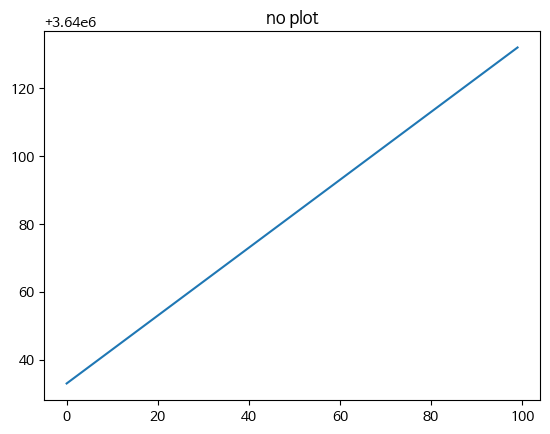

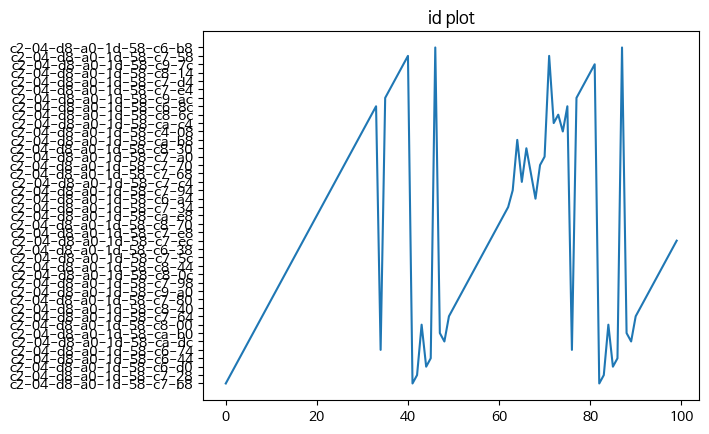

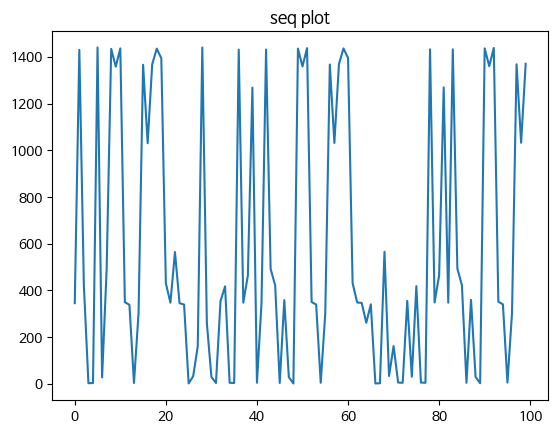

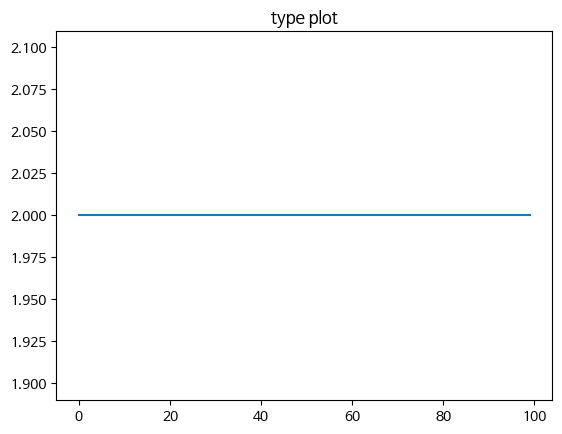

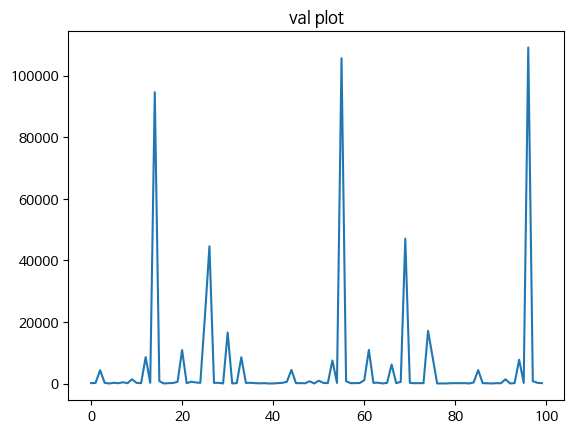

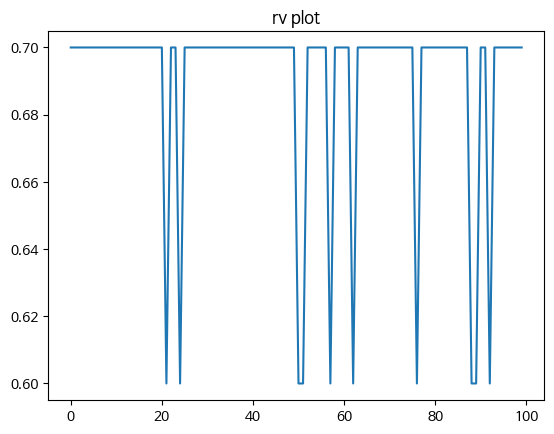

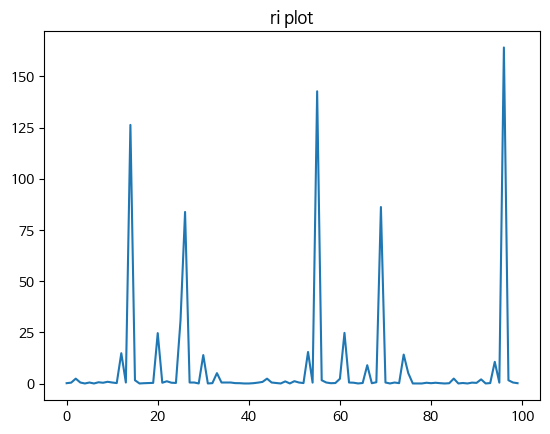

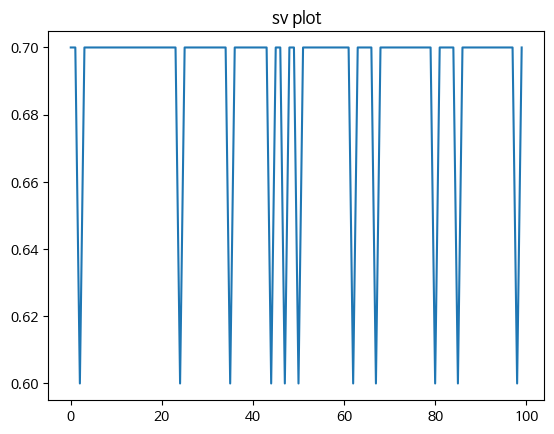

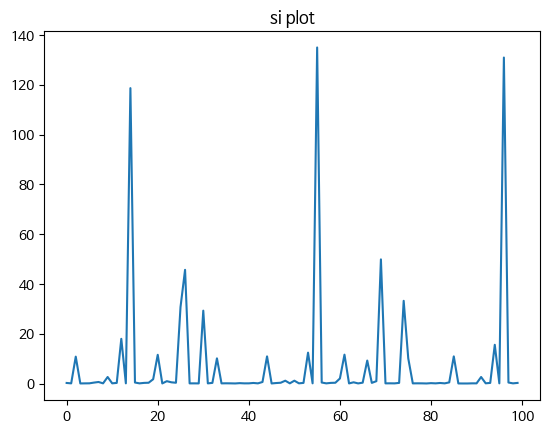

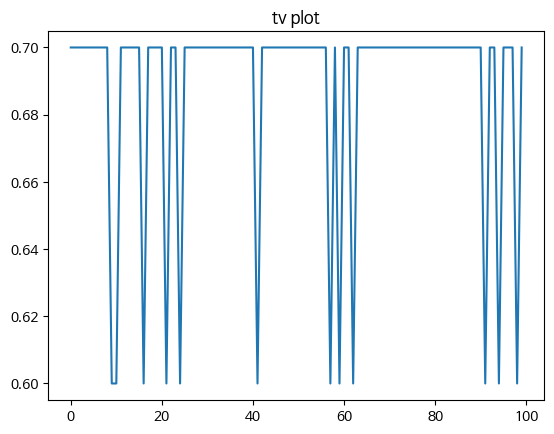

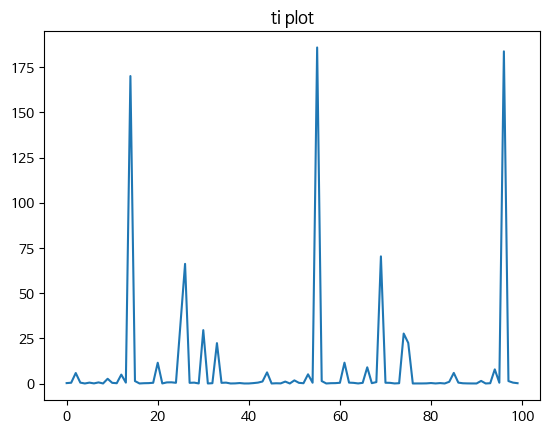

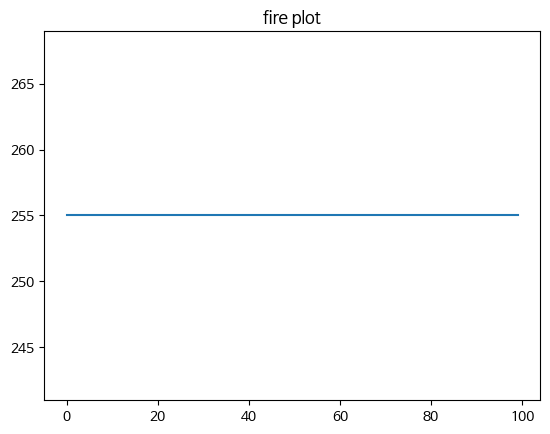

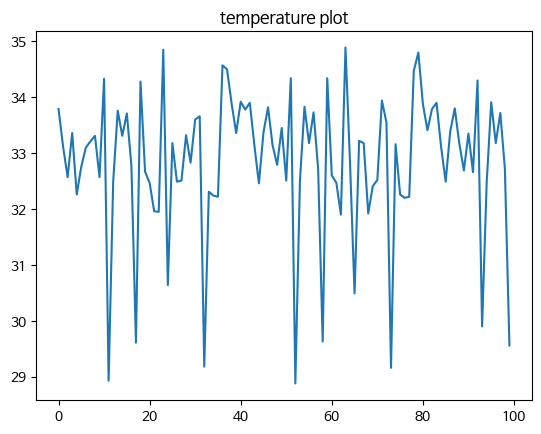

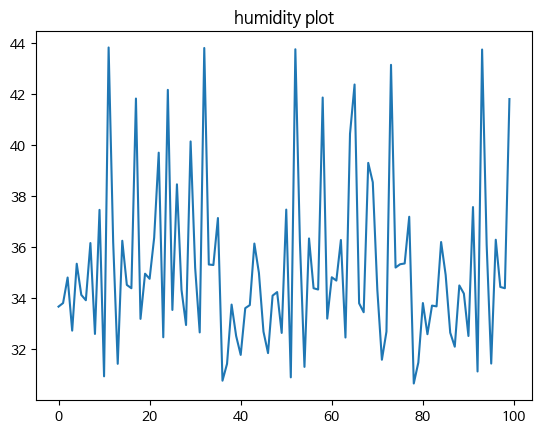

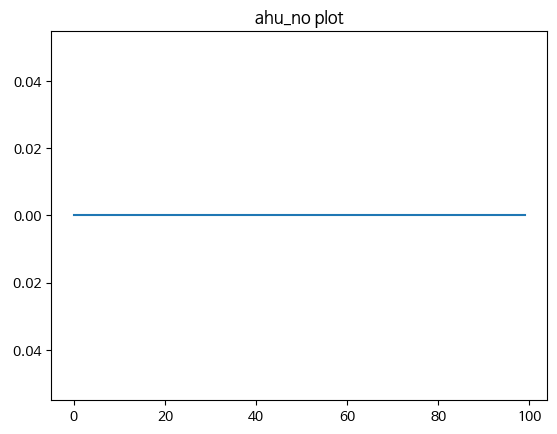

In [32]:
for i in range(len(e1col)):
  try:
      plt.figure(i)
      plt.plot(e.iloc[:100].index, e.iloc[:100][e1col[i]].values)
      plt.title(f'{e1col[i]} plot')
      plt.show()
  except:
      pass

In [33]:
# with open("/content/drive/MyDrive/ime_project/done/e_complete.pkl", 'wb') as file:
#     pickle.dump(e_fin_dct, file)

In [46]:
e_fin_dct[1].to_csv('/content/drive/MyDrive/ime_project/done/e1_complete.csv')

# plant 전처리

In [34]:
plant.head()

,no,id,seq,air,monoxide,dioxide,pm2d5,pm10,temperature,humidit,score,cdate
0,1333503,c2-01-d8-a0-1d-58-cf-4c,912,25,0,400,13,14,25.86,42.61,NaN,2023-01-01 00:00:01
1,1333504,c2-01-d8-a0-1d-58-65-44,337,104,0,400,14,15,26.23,42.56,NaN,2023-01-01 00:00:09
2,1333505,c2-01-d8-a0-1d-58-ce-74,663,0,1,447,15,17,27.17,41.22,NaN,2023-01-01 00:00:18
3,1333506,c2-01-d8-a0-1d-59-b4-14,943,29,0,413,23,26,25.41,46.23,NaN,2023-01-01 00:00:19
4,1333507,c2-01-d8-a0-1d-58-68-a4,888,164,0,585,11,12,26.17,36.11,NaN,2023-01-01 00:00:26


In [35]:
id_plant2device # 1&2&3 , 4&5 , 6&7 , 8&9 , 10&11 , 12&13&14

{'c2-01-d8-a0-1d-58-cf-50': 3,
 'c2-01-d8-a0-1d-58-ca-e4': 5,
 'c2-01-d8-a0-1d-59-b4-b8': 7,
 'c2-01-d8-a0-1d-58-68-a4': 9,
 'c2-01-d8-a0-1d-58-cd-a0': 11,
 'c2-01-d8-a0-1d-58-6e-0c': 14}

In [36]:
plant['ahu_no'] = 0
plant_fin_dct = {}

for i in range(1, 4):
    plant_fin_dct[i] = plant[plant['id']==list(id_plant2device.keys())[0]]
    plant_fin_dct[i]['ahu_no'] = i

for i in range(4, 6):
    plant_fin_dct[i] = plant[plant['id']==list(id_plant2device.keys())[1]]
    plant_fin_dct[i]['ahu_no'] = i

for i in range(6, 8):
    plant_fin_dct[i] = plant[plant['id']==list(id_plant2device.keys())[2]]
    plant_fin_dct[i]['ahu_no'] = i

for i in range(8, 10):
    plant_fin_dct[i] = plant[plant['id']==list(id_plant2device.keys())[3]]
    plant_fin_dct[i]['ahu_no'] = i

for i in range(10, 12):
    plant_fin_dct[i] = plant[plant['id']==list(id_plant2device.keys())[4]]
    plant_fin_dct[i]['ahu_no'] = i

for i in range(12, 15):
    plant_fin_dct[i] = plant[plant['id']==list(id_plant2device.keys())[5]]
    plant_fin_dct[i]['ahu_no'] = i

for i in range(1, 15):
    plant1 = plant_fin_dct[i]
    plant1.cdate = pd.to_datetime(plant1.cdate)
    plant1['cdate'] = plant1['cdate'].dt.floor('10T')
    plant1.drop_duplicates(subset='cdate', inplace=True)
    plant1.set_index('cdate', inplace=True)

In [37]:
plant_fin_dct[1].head()

,no,id,seq,air,monoxide,dioxide,pm2d5,pm10,temperature,humidit,score,ahu_no
cdate,,,,,,,,,,,,
2023-01-01 00:00:00,1333515,c2-01-d8-a0-1d-58-cf-50,910,218,0,602,12,13,26.18,36.31,NaN,1
2023-01-01 00:10:00,1333665,c2-01-d8-a0-1d-58-cf-50,920,213,0,603,11,12,26.10,36.34,NaN,1
2023-01-01 00:20:00,1333815,c2-01-d8-a0-1d-58-cf-50,930,208,0,600,12,13,26.08,36.52,NaN,1
2023-01-01 00:30:00,1333950,c2-01-d8-a0-1d-58-cf-50,939,215,0,601,11,12,26.07,36.52,NaN,1
2023-01-01 00:40:00,1334098,c2-01-d8-a0-1d-58-cf-50,949,217,0,600,10,11,26.14,36.27,NaN,1


In [38]:
plant1 = plant_fin_dct[1]
plant1col = list(plant1.columns)

for i in range(len(plant1col)):
  print(f'{plant1col[i]:<{15}} 결측치: {(plant1[plant1col[i]].isna().sum()/len(plant1[plant1col[i]]))*100:.2f} %')

# score 제거
for i in range(1,15):
  plant_fin_dct[i].drop(['score'], axis=1, inplace=True)

no              결측치: 0.00 %
id              결측치: 0.00 %
seq             결측치: 0.00 %
air             결측치: 0.00 %
monoxide        결측치: 0.00 %
dioxide         결측치: 0.00 %
pm2d5           결측치: 0.00 %
pm10            결측치: 0.00 %
temperature     결측치: 0.00 %
humidit         결측치: 0.00 %
score           결측치: 100.00 %
ahu_no          결측치: 0.00 %


In [39]:
plant1 = plant_fin_dct[1]
plant1col = list(plant1.columns)

for i in range(len(plant1col)):
  print(f'{plant1col[i]:<{15}} 결측치: {(plant1[plant1col[i]].isna().sum()/len(plant1[plant1col[i]]))*100:.2f} %')

no              결측치: 0.00 %
id              결측치: 0.00 %
seq             결측치: 0.00 %
air             결측치: 0.00 %
monoxide        결측치: 0.00 %
dioxide         결측치: 0.00 %
pm2d5           결측치: 0.00 %
pm10            결측치: 0.00 %
temperature     결측치: 0.00 %
humidit         결측치: 0.00 %
ahu_no          결측치: 0.00 %


In [47]:
plant_fin_dct[1].to_csv('/content/drive/MyDrive/ime_project/done/plant1_complete.csv')

In [40]:
# with open("/content/drive/MyDrive/ime_project/done/plant_complete.pkl", 'wb') as file:
#     pickle.dump(plant_fin_dct, file)

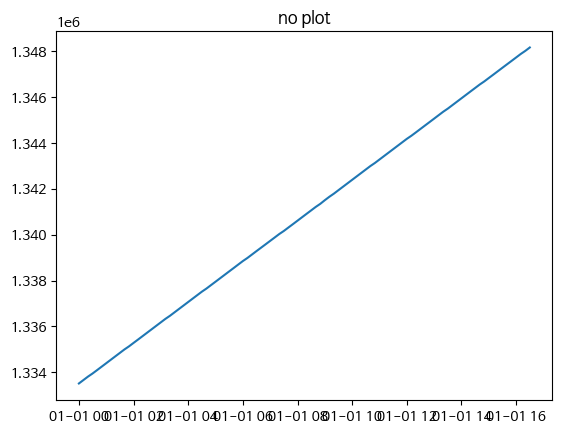

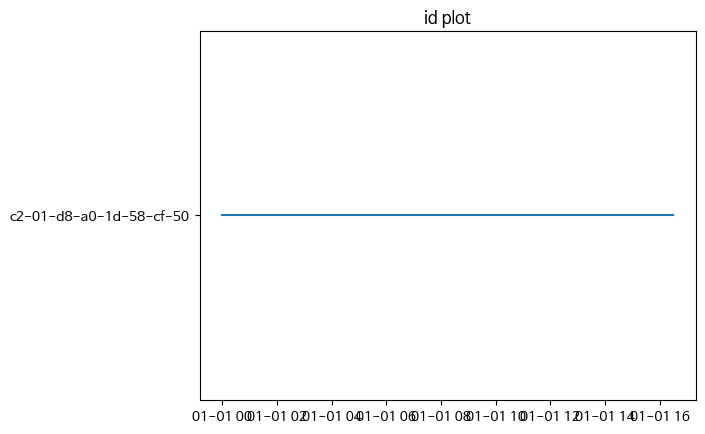

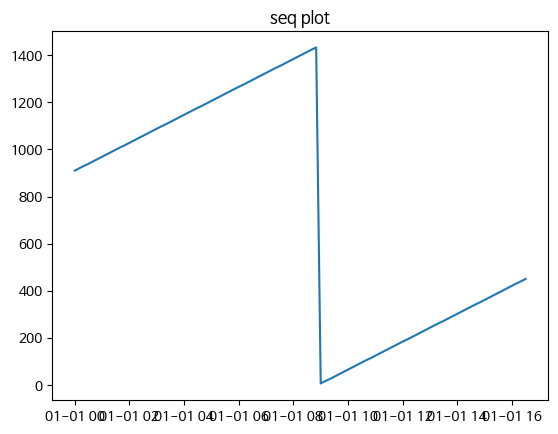

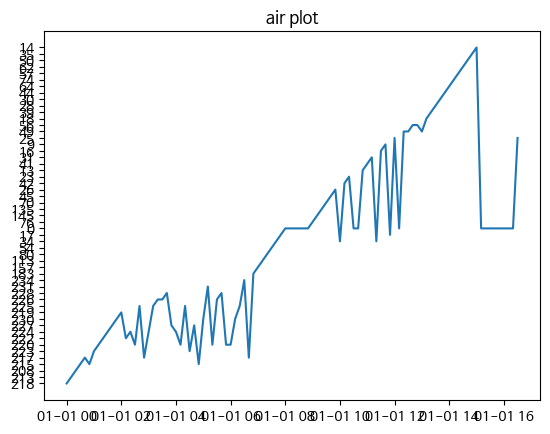

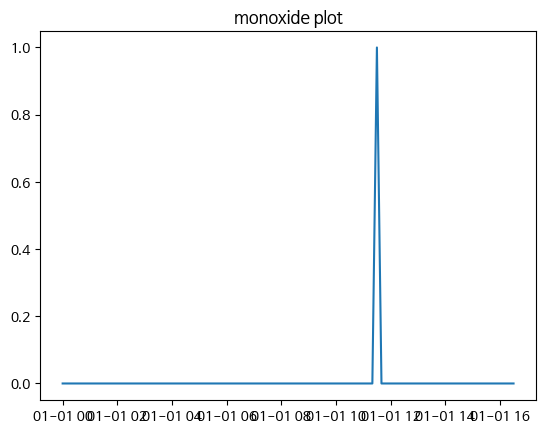

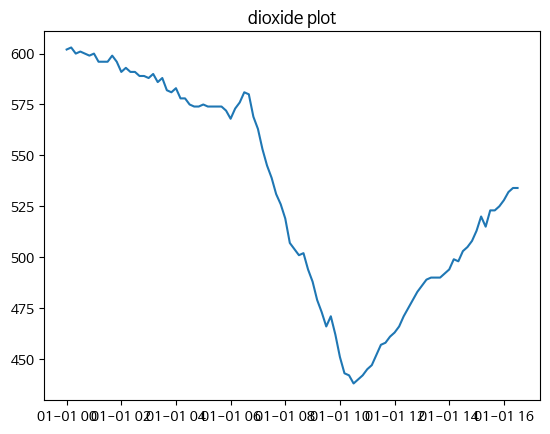

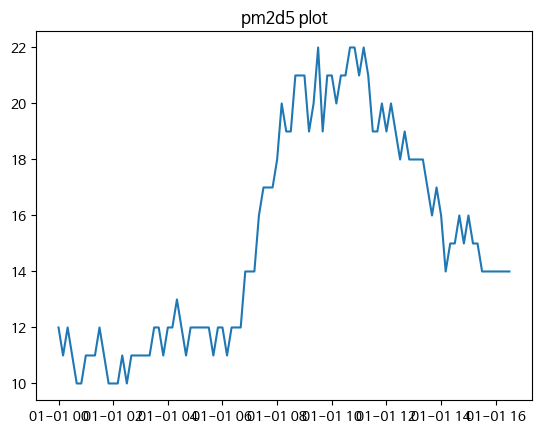

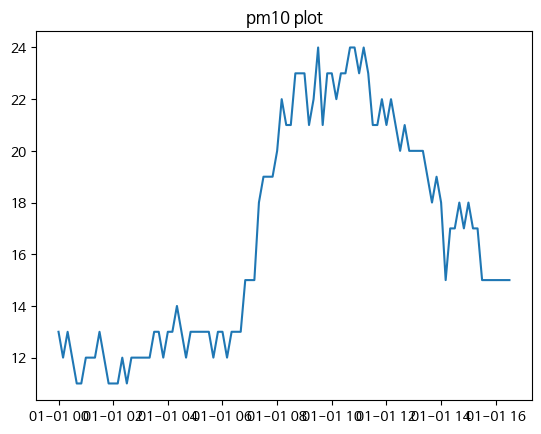

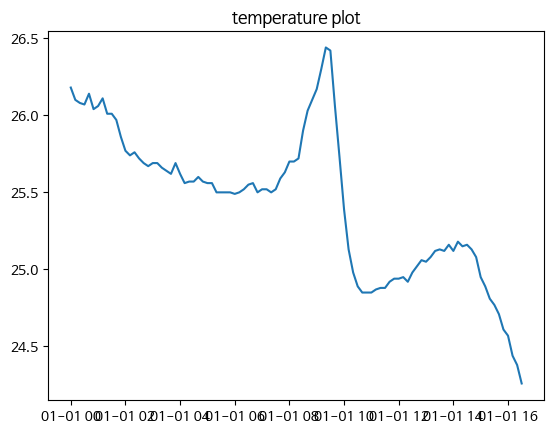

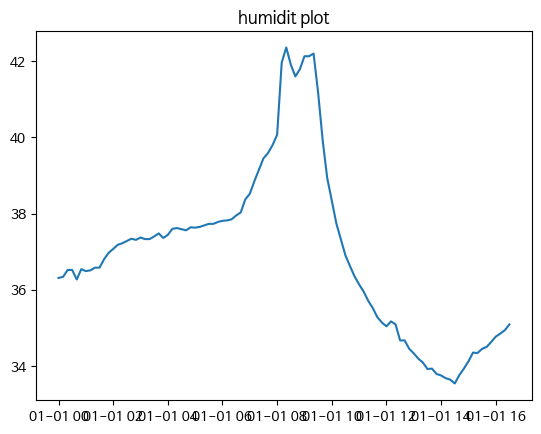

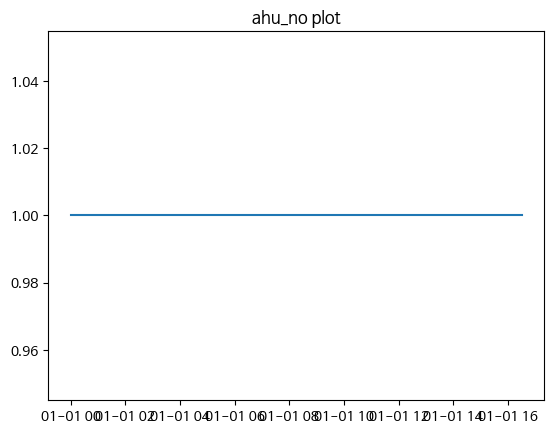

In [41]:
for i in range(len(plant1col)):
  try:
      plt.figure(i)
      plt.plot(plant1.iloc[:100].index, plant1.iloc[:100][plant1col[i]].values)
      plt.title(f'{plant1col[i]} plot')
      plt.show()
  except:
      pass